In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using KrylovKit
using Roots

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64 
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 8
    A::Int64 = Z + N
    
    # parameters for initial density
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    # parameters for ph interaction
    t₀ = -1800
    t₃ = 12871
    x₀ = 0.0
    x₃ = 0.0
    α = 1/3
    
    # parameters for pp interaction
    v_ρ = 930
    αp = 1.2
    tp₀ = -831
    tp₃ = 6*v_ρ/0.16^αp
    
    # radial grids
    Nr::Int64 = 200
    Δr = 0.1
    rs::T = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, R/Δr) + 1
    
    # energy
    Emin = -70.0
    Emax = 0.0
    ΔE = 1.0
    Es::T = range(Emin, Emax, step=ΔE)
    
    # maximal value of angular momentum
    lmax::Int64 = 5
    nstates_max::Int64 = 1000
    
    # potential
    Vs_central::Matrix{Float64} = zeros(Float64, Nr+1, 2)
    Vs_eff::Vector{Float64} = zeros(Float64, Nr+1)
    #λq::Vector{Float64} = zeros(Float64, 2)
    #Δq::Vector{Float64} = [12/sqrt(A), 12/sqrt(A)]
    
    # working arrays for integrating HF eq.
    ys_p::Vector{Float64} = similar(rs)
    ys_m::Vector{Float64} = similar(rs)
    
    Gs::Vector{Float64} = similar(rs)
    As::Vector{Float64} = similar(rs)
    
    # derivative
    dψ::Vector{Float64} = similar(rs)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1 # q=1 for neutron, q=2 for proton
end

@with_kw struct Densities
    # normal densities
    ρ_q::Matrix{Float64}; @assert size(ρ_q, 2) === 2
    τ_q::Matrix{Float64}; @assert size(τ_q, 2) === 2
    ρ_tot::Vector{Float64}
    τ_tot::Vector{Float64}
    
    # pairing densities
    ρp_q::Matrix{Float64}; @assert size(ρp_q, 2) === 2
    ρp_tot::Vector{Float64}
end

#=
@with_kw struct PairingDensities
    ρp_q::Matrix{Float64}; @assert size(ρp_q, 2) === 2
    ρp_tot::Vector{Float64}
end
=#

@with_kw struct SingleParticleStates
    nstates_max::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates_max
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates_max
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates_max
    occ::Vector{Float64}; @assert length(occ) === nstates_max
    
    Δs::Vector{Float64}; @assert length(Δs) === nstates_max
    λq::Vector{Float64}; @assert length(λq) === 2
end

end # module My

Main.My

In [3]:
function make_states(param)
    @unpack Nr, nstates_max = param 
    
    spEs  = zeros(Float64, nstates_max)
    spEs .= 1e10
    
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr+1, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    Δs = zeros(Float64, nstates_max)
    λq = zeros(Float64, 2)
    
    My.SingleParticleStates(nstates_max, spEs, qnums, wfs, occ, Δs, λq)
end

make_states (generic function with 1 method)

In [4]:
param = My.PhysicalParam(N=10)

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 10
  A: Int64 18
  r₀: Float64 1.2
  R: Float64 3.1448896730506757
  a: Float64 0.67
  ρ₀: Float64 0.13815533254504805
  t₀: Float64 -1800.0
  t₃: Float64 12871.0
  x₀: Float64 0.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  v_ρ: Float64 930.0
  αp: Float64 1.2
  tp₀: Float64 -831.0
  tp₃: Float64 50314.15921851407
  Nr: Int64 200
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 32
  Emin: Float64 -70.0
  Emax: Float64 0.0
  ΔE: Float64 1.0
  Es: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  lmax: Int64 5
  nstates_max: Int64 1000
  Vs_central: Array{Float64}((201, 2)) [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]
  Vs_eff: Array{Float64}((201,)) [0.

In [5]:
function initial_density(param; κ=[0.0, 0.0])
    @unpack A, N, Z, r₀, R, a, ρ₀, rs, Nr = param
    
    @assert length(κ) == 2
    
    # normal densities
    ρ_q = zeros(Float64, Nr+1, 2)
    τ_q = zeros(Float64, Nr+1, 2)
    ρ_tot = zeros(Float64, Nr+1)
    τ_tot = zeros(Float64, Nr+1)
    
    @. ρ_q[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρ_q[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρ_tot = ρ_q[:,1] + ρ_q[:,2]
    
    # pairing densities
    ρp_q = zeros(Float64, Nr+1, 2)
    ρp_tot = zeros(Float64, Nr+1)
    
    @. ρp_q[:,1] = κ[1]*(ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρp_q[:,2] = κ[2]*(ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρp_tot = ρp_q[:,1] + ρp_q[:,2]
    
    return My.Densities(ρ_q, τ_q, ρ_tot, τ_tot, ρp_q, ρp_tot)
end

function test_initial_density(param)
    @unpack rs = param 
    @time dens = initial_density(param; κ=[0.1, 0.1])
    p = plot()
    plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
    plot!(rs, dens.ρ_tot; label="ρ_tot")
    plot!(rs, dens.ρp_q[:,1]; label="ρp_n")
    plot!(rs, dens.ρp_q[:,2]; label="ρp_p")
end

test_initial_density (generic function with 1 method)

  0.000008 seconds (7 allocations: 15.312 KiB)


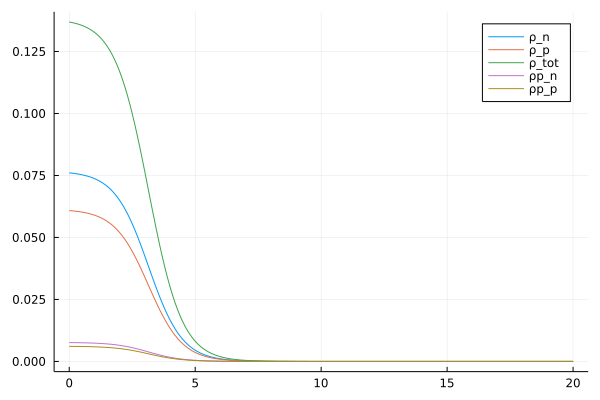

In [6]:
test_initial_density(param)

In [7]:
function calc_potential!(param, dens)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, rs, Vs_central = param 
    @unpack ρ_q, ρ_tot, ρp_q, ρp_tot = dens
    #@unpack l, j, q = qnum
    
    @views for q in 1:2
        # t₀ term
        @. Vs_central[:,q]  = t₀*((1+0.5x₀)*ρ_tot - (x₀+0.5)*ρ_q[:,q])
        
        # t₃ term
        @. Vs_central[:,q] +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρ_tot^(α+1)
        @. Vs_central[:,q] += -1/12*t₃*(x₃+0.5)*α*(ρ_tot^(α-1))*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        @. Vs_central[:,q] += -1/12*t₃*(x₃+0.5)*2*(ρ_tot^α)*ρ_q[:,q]
        
        # pairing term
        @. Vs_central[:,q] += (1/24)*tp₃*αp*(ρ_tot^(αp-1))*
                    (ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2]) 
        
        # centrifugal potential
        #@. Vs_central[:,q] += M*l*(l+1)/rs^2
    end
end

function test_calc_potential!(param; l=0, κ=[0.3, 0.3])
    @unpack rs, Vs_central = param
    
    p = plot(; ylim=(-60, 10))
    
    dens = initial_density(param; κ=[0.0, 0.0])
    
    @time calc_potential!(param, dens)
    plot!(p, rs, Vs_central[:,1]; label="V_n κ=0.0")
    plot!(p, rs, Vs_central[:,2]; label="V_p κ=0.0")
    
    dens = initial_density(param; κ=κ)
    
    @time calc_potential!(param, dens)
    plot!(p, rs, Vs_central[:,1]; label="V_n κ=$κ")
    plot!(p, rs, Vs_central[:,2]; label="V_p κ=$κ")
end

test_calc_potential! (generic function with 1 method)

  0.000019 seconds
  0.000016 seconds


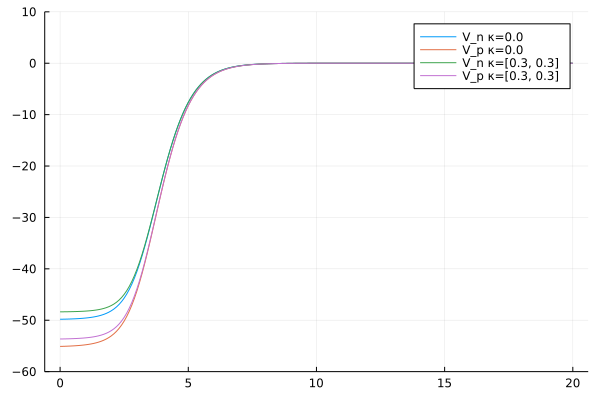

In [8]:
test_calc_potential!(param; l=0, κ=[0.3, 0.3])

In [9]:
function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFeq!(param, E, qnum)
    @unpack M, Nr, Δr, rs, ir_matching, Vs_central, 
        ys_p, ys_m, Gs, As = param
    
    @unpack l, j, q = qnum
    
    @. As = 1 - (Δr*Δr/12)*(Vs_central[:,q] + M*l*(l+1)/rs^2 - E)/M
    
    # outward integration
    fill!(ys_p, 0)
    ys_p[1] = 0.0
    ys_p[2] = Δr^(l+1)
    
    if l !== 1
        Gs[1] = 0.0
    else
        Gs[1] = - Δr*Δr/6
    end
    Gs[2] = As[2]*ys_p[2]
    
    for ir in 3:ir_matching+1
        Gs[ir] = 12ys_p[ir-1] - 10Gs[ir-1] - Gs[ir-2]
        ys_p[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_p, rs)
    
    # inward integration 
    fill!(ys_m, 0)
    ys_m[Nr+1] = 0.0
    ys_m[Nr  ] = Δr
    
    Gs[Nr+1] = 0.0
    Gs[Nr  ] = As[Nr]*ys_m[Nr]
    
    for ir in Nr-1: -1: ir_matching-1
        Gs[ir] = 12ys_m[ir+1] - 10Gs[ir+1] - Gs[ir+2]
        ys_m[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_m, rs)
    
    return
end

function test_integrate_HFeq!(param; E=-40.0, l=0, q=1)
    @unpack rs, Nr, Δr, Vs_central, ys_p, ys_m = param 
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    calc_potential!(param, dens)
    
    @time integrate_HFeq!(param, E, qnum)
    
    p = plot()
    plot!(rs, ys_p; label="ys_p")
    plot!(rs, ys_m; label="ys_m")
end

test_integrate_HFeq! (generic function with 1 method)

  0.000006 seconds (1 allocation: 1.766 KiB)


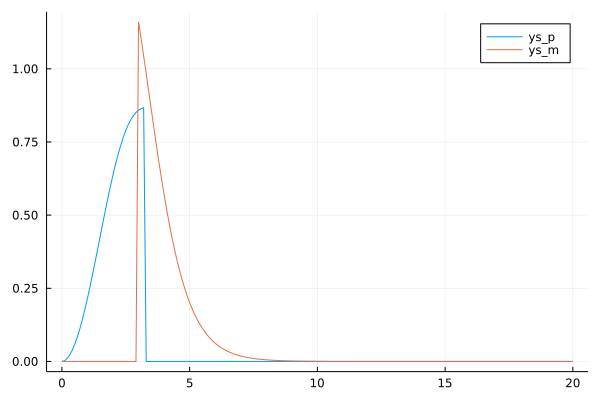

In [10]:
test_integrate_HFeq!(param; E=-30, l=1)

In [11]:
function calc_matching_condition(param)
    @unpack Δr, ir_matching, ys_p, ys_m = param
    
    ir = ir_matching 
    
    a = ys_p[ir]
    b = ys_m[ir]
    c = (ys_p[ir+1] - ys_p[ir-1])/2Δr
    d = (ys_m[ir+1] - ys_m[ir-1])/2Δr
    
    return a*d - b*c
end

calc_matching_condition (generic function with 1 method)

In [12]:
function test_calc_matching_condition(param; l=0, q=1)
    @unpack Nr, rs, Es, Δr,  ys_p, ys_m = param 
    
    fs = similar(Es)
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    calc_potential!(param, dens)
    
    for iE in 1:length(Es)
        integrate_HFeq!(param, Es[iE], qnum)
        fs[iE] = calc_matching_condition(param)
    end
    
    fs
end

test_calc_matching_condition (generic function with 1 method)

  0.113297 seconds (1.21 M allocations: 60.291 MiB, 8.48% gc time, 99.79% compilation time)


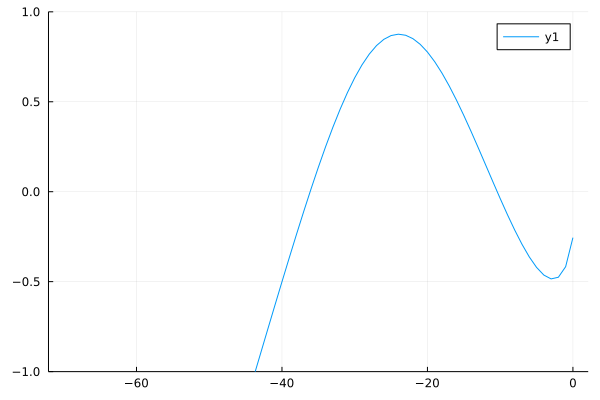

In [13]:
@time fs = test_calc_matching_condition(param; l=0)
plot(param.Es, fs; ylim=(-1,1))

In [153]:
function construct_eigenfunction!(ys, param, E, qnum)
    @unpack Nr, Δr, rs, ir_matching, ys_p, ys_m = param 
    
    integrate_HFeq!(param, E, qnum)
    
    ratio = ys_p[ir_matching]/ys_m[ir_matching]
    @. ys_m *= ratio 
    
    for ir in 1:ir_matching
        ys[ir] = ys_p[ir]
    end
    for ir in ir_matching+1:Nr+1
        ys[ir] = ys_m[ir]
    end
    
    normalize!(ys, rs)
    
    return
end

function calc_states!(states, param, dens)
    @unpack rs, Es, lmax, Vs_central = param 
    @unpack spEs, qnums, wfs = states
    
    fill!(spEs, 1e10)
    
    istate = 0
    calc_potential!(param, dens)
    for l in 0:lmax, q in 1:2
        qnum = My.QuantumNumbers(l=l, q=q)
        
        function f(E)
            integrate_HFeq!(param, E, qnum)
            calc_matching_condition(param)
        end
        
        for i in 1:length(Es)-1
            f₁ = f(Es[i])
            f₂ = f(Es[i+1])

            @views if f₁*f₂ < 0
                E = find_zero(f, (Es[i], Es[i+1]), Bisection())
                istate += 1
                spEs[istate] = E
                qnums[istate] = qnum
                construct_eigenfunction!(wfs[:, istate], param, E, qnum)
            end
        end
    end
end

function sort_states!(states)
    @unpack spEs, qnums, wfs = states
    p = sortperm(spEs)
    wfs[:] = wfs[:,p]
    spEs[:] = spEs[p]
    qnums[:] = qnums[p]
    return 
end

function calc_occ!(states, param, q)
    @unpack A, Z, N = param
    @unpack nstates_max, spEs, qnums, occ = states
    
    Aq = N
    if q === 2
        Aq = Z
    end
    nq = 0
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l, j = qnums[i]
        
        if qnums[i].q === q 
            if nq + 2(2l+1) ≤ Aq
                occ[i] = 1
                nq += 2(2l+1)
            elseif nq < Aq
                occ[i] = (Aq - nq)/2(2l+1)
                nq = Aq
            else
                occ[i] = 0.0
            end
        end
    end
    
    @assert nq === Aq
    
    return 
end

function show_states(states)
    @unpack nstates_max, spEs, qnums, occ, Δs = states
    println("")
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        println("i = $i: ")
        @show spEs[i] occ[i] Δs[i] qnums[i]
        println("")
    end
end

show_states (generic function with 1 method)

In [15]:
function test_calc_states!(param)
    @unpack Nr, rs = param 
    
    dens = initial_density(param)
    states = make_states(param)
    
    @time calc_states!(states, param, dens)
    @time sort_states!(states)
    @time calc_occ!(states, param, 1)
    @time calc_occ!(states, param, 2)
    
    show_states(states)
end

test_calc_states! (generic function with 1 method)

In [17]:
param = My.PhysicalParam(N=8,Z=8, Nr=200)
test_calc_states!(param)

  0.019066 seconds (2.35 k allocations: 3.845 MiB)
  0.000657 seconds (7 allocations: 1.572 MiB)
  0.000002 seconds
  0.000001 seconds

i = 1: 
spEs[i] = -37.53992173567087
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 2: 
spEs[i] = -37.53992173567087
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 3: 
spEs[i] = -25.124175256913524
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 4: 
spEs[i] = -25.124175256913524
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 5: 
spEs[i] = -11.852355164597334
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1


i = 6: 
spEs[i] = -11.852355164597334
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 7: 
spEs[i] = -10.521397308281726


In [18]:
function first_deriv!(dψ, rs, ψ)
    Nr = length(rs)
    Δr = rs[2] - rs[1]
    
    dψ[1] = ψ[2]/2Δr
    for ir in 2:Nr-1
        dψ[ir] = (ψ[ir+1] - ψ[ir-1])/2Δr
    end
    dψ[Nr] = -ψ[Nr-1]/2Δr
    
    return 
end

function calc_density!(dens, param, states)
    @unpack rs, dψ = param
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρ_q, τ_q, ρ_tot, τ_tot = dens
    
    fill!(ρ_q, 0)
    fill!(τ_q, 0)
    @views for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i]
        first_deriv!(dψ, rs, ψ)
        
        @. ρ_q[:,q] += occ[i] * 2(2l+1)/4π * (ψ/rs)^2
        @. τ_q[:,q] += occ[i] * 2(2l+1)/4π * (dψ/rs - ψ/(rs*rs))*(dψ/rs - ψ/(rs*rs))
        @. τ_q[:,q] += occ[i] * 2(2l+1)/4π * l*(l+1)*(ψ/rs^2)^2
    end
    
    @views @. begin
        ρ_q[1,:] = 4ρ_q[2,:] - 6ρ_q[3,:] + 4ρ_q[4,:] - ρ_q[5,:]
        τ_q[1,:] = 4τ_q[2,:] - 6τ_q[3,:] + 4τ_q[4,:] - τ_q[5,:]

        ρ_tot = ρ_q[:,1] + ρ_q[:,2]
        τ_tot = τ_q[:,1] + τ_q[:,2]
    end
end

function test_calc_density(param)
    @unpack Nr, rs = param 
    
    p = plot()
    
    dens = initial_density(param)
    plot!(p, rs, dens.ρ_q[:,1]; label="ρ_n₀")
    plot!(p, rs, dens.ρ_q[:,2]; label="ρ_p₀")
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    calc_occ!(states, param, 1)
    calc_occ!(states, param, 2)
    
    @time calc_density!(dens, param, states)
    
    plot!(p, rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(p, rs, dens.τ_q[:,1]; label="τ_n")
    plot!(p, rs, dens.ρ_q[:,2]; label="ρ_p")
    plot!(p, rs, dens.τ_q[:,2]; label="τ_p")
    display(p)
    
end

test_calc_density (generic function with 1 method)

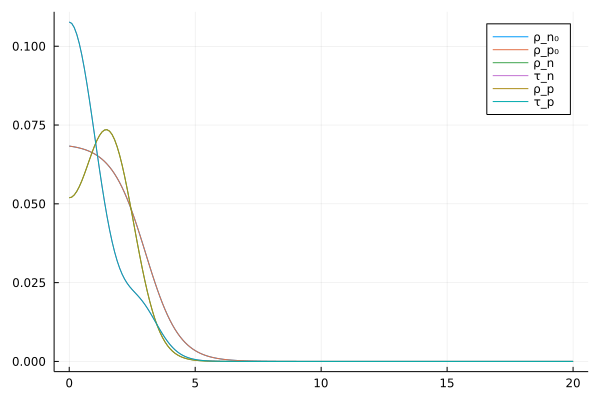

  0.000029 seconds


In [19]:
test_calc_density(param)

In [22]:
function calc_total_energy(param, dens)
    @unpack M, A, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, Δr, Nr, rs = param 
    @unpack ρ_q, τ_q, ρ_tot, τ_tot, ρp_q = dens
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += M*τ_tot
        
        # t₀ term
        @. ε += +0.5t₀*(1+0.5x₀)*ρ_tot*ρ_tot
        @. ε += -0.5t₀*(x₀+0.5)*(ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        
        # t₃ term
        @. ε += +1/12*t₃*(1+0.5x₃)*ρ_tot^(α+2)
        @. ε += -1/12*t₃*(x₃+0.5)*ρ_tot^α*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        
        # pairing energy
        @. ε += (1/4 )*tp₀*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
        @. ε += (1/24)*tp₃*(ρ_tot^αp)*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
    end
    
    return sum((@. 4π*rs^2 * ε)) * Δr
end

function calc_total_energy2(param, dens, states)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, Δr, Nr, rs = param 
    @unpack ρ_q, τ_q, ρ_tot, τ_tot, ρp_q = dens
    @unpack nstates_max, spEs, qnums, occ = states
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += 0.5M*τ_tot
        
        @. ε += -α/24*t₃*(1+0.5x₃)*ρ_tot^(α+2)
        @. ε += +α/24*t₃*(x₃+0.5)*ρ_tot^α*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        
        # pairing term
        @. ε += (1/4 )*tp₀*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
        @. ε += (1-0.5αp)*(1/24)*tp₃*(ρ_tot^αp)*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
    end
    
    E = sum((@. 4π*rs^2 * ε)) * Δr
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l = qnums[i]
        
        E += 0.5*2(2l+1)*occ[i]*spEs[i]
    end
    
    return E
end


function HF_calc(param; iter_max=10, show_result=false)
    @unpack rs, Δr = param
    
    dens = initial_density(param)
    states = make_states(param)
    
    Etots  = zeros(Float64, iter_max)
    Etots2 = zeros(Float64, iter_max)
    
    @time for iter in 1:iter_max
        calc_states!(states, param, dens)
        sort_states!(states)
        calc_occ!(states, param, 1)
        calc_occ!(states, param, 2)
        
        calc_density!(dens, param, states)
        
        Etots[iter]  = calc_total_energy(param, dens)
        Etots2[iter] = calc_total_energy2(param, dens, states)
    end
    
    E = calc_total_energy(param, dens)
    E₂ = calc_total_energy2(param, dens, states)
    
    if show_result
        @show E E₂
        show_states(states)

        p = plot()
        plot!(Etots; label="Etots", marker=:dot)
        plot!(Etots2; label="Etots2", marker=:dot)
        display(p)

        p = plot()
        plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
        plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
        display(p)
    end
    
    return states, dens
end

HF_calc (generic function with 1 method)

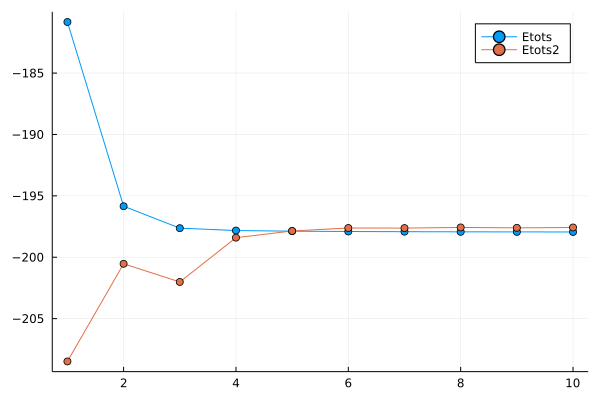

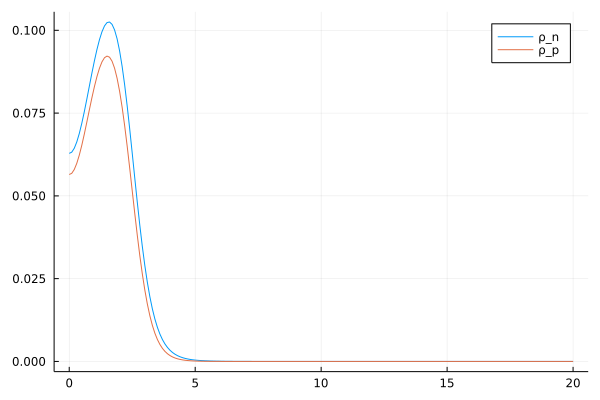

  0.107560 seconds (22.38 k allocations: 52.449 MiB, 8.18% gc time)
E = -197.94262112271394
E₂ = -197.57760869126216

i = 1: 
spEs[i] = -38.57744934539942
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -35.666597173240135
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -24.42081041145208
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -21.03437142974254
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -8.044800416762424
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -4.78124818116845
occ[i] = 0.2
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1


i = 7: 
spEs[i] = -4.26468194544275
occ[i] = 0.0
Δs[i] = 0.0

In [24]:
param = My.PhysicalParam(N=10,Z=8, Nr=200)
HF_calc(param; iter_max=10, show_result=true)
;

# HF+BCS

In [25]:
function calc_pairing_gap!(states, param, dens, q)
    @unpack Nr, Δr, tp₀, tp₃, αp, Vs_eff = param
    @unpack nstates_max, spEs, qnums, wfs, Δs = states
    @unpack ρ_tot, ρp_q = dens
    
    @. Vs_eff = tp₀ + (1/6)*tp₃*(ρ_tot^αp)
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        if qnums[i].q == q
            Δs[i] = 0.0
            for ir in 1:Nr+1
                Δs[i] += Vs_eff[ir]*ρp_q[ir,q]*wfs[ir,i]*wfs[ir,i]
            end
            Δs[i] *= -0.5Δr
        end
    end
end

function test_calc_pairing_gap!(param)
    dens = initial_density(param; κ=[0.3,0.3])
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    @time calc_pairing_gap!(states, param, dens, 1)
    @time calc_pairing_gap!(states, param, dens, 2)
    
    @unpack spEs, Δs = states
    p = plot()
    plot!(p, Δs[spEs .≠ 1e10])
end

test_calc_pairing_gap! (generic function with 1 method)

  0.000003 seconds
  0.000003 seconds


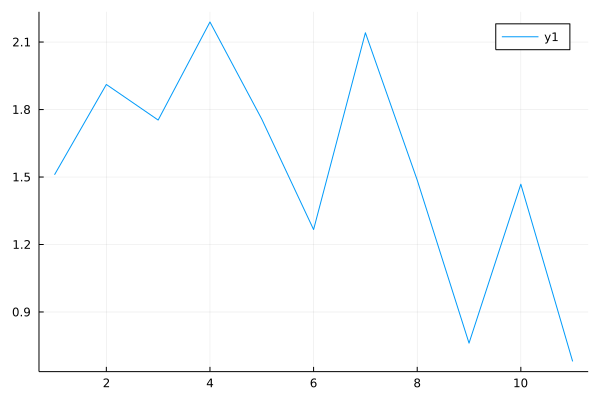

In [26]:
test_calc_pairing_gap!(param)

In [27]:
function calc_particle_number(param, states, q, λ)
    @unpack nstates_max, spEs, qnums, occ, Δs = states
    
    Aq = 0
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l = qnums[i]
        
        Δ = Δs[i]
        ε = spEs[i] - λ
        
        if qnums[i].q == q
            Aq += 2(2l+1)*0.5(1 - ε/sqrt(ε*ε + Δ*Δ))
        end
    end
    
    return Aq
end


function calc_chemical_potential!(states, param, q; λmin=-50, λmax=0.0)
    @unpack A, Z, N = param
    @unpack λq = states
    
    f(λ) = calc_particle_number(param, states, q, λ) - N
    λq[q] = find_zero(f, (λmin, λmax), Bisection())
    
    return
end

calc_chemical_potential! (generic function with 1 method)

In [28]:
function test_calc_chemical_potential!(param)
    @unpack A = param
    dens = initial_density(param; κ=[0.3, 0.3])
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    calc_pairing_gap!(states, param, dens, 1)
    calc_pairing_gap!(states, param, dens, 2)
    
    @time calc_chemical_potential!(states, param, 1)
    @time calc_chemical_potential!(states, param, 2)
    @unpack λq = states
    
    N = calc_particle_number(param, states, 1, λq[1])
    Z = calc_particle_number(param, states, 2, λq[2])
    @show λq N Z
    
    return
end

test_calc_chemical_potential! (generic function with 1 method)

In [30]:
test_calc_chemical_potential!(param)

  0.000039 seconds (7 allocations: 2.031 KiB)
  0.000026 seconds (7 allocations: 2.031 KiB)
λq = [-13.142683461528955, -16.117307974235498]
N = 10.0
Z = 10.000000000000004


In [31]:
function calc_occ_BCS!(states, param, q)
    @unpack nstates_max, spEs, qnums, occ, Δs, λq = states
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l = qnums[i]
        
        if qnums[i].q == q
            Δ = Δs[i]
            ε = spEs[i] - λq[q]

            occ[i] = 0.5(1 - ε/sqrt(ε*ε + Δ*Δ))
        end
    end
end

function calc_pairing_density!(dens, param, states)
    @unpack rs = param
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρp_q, ρp_tot = dens
    
    fill!(ρp_q, 0)
    @views for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i] 
        
        uv = sqrt((1 - occ[i])*occ[i])
        
        @. ρp_q[:,q] += 2(2l+1)/4π * uv * (ψ/rs)^2
    end
    
    @views @. begin
        ρp_q[1,:] = 4ρp_q[2,:] - 6ρp_q[3,:] + 4ρp_q[4,:] - ρp_q[5,:]

        ρp_tot = ρp_q[:,1] + ρp_q[:,2]
    end
end

function test_calc_pairing_density!(param; κ=[0.3, 0.3],
        neutron_pairing=false, proton_pairing=false)
    @unpack rs = param
    
    if !neutron_pairing
        κ[1] = 0.0
    end
    if !proton_pairing
        κ[2] = 0.0
    end
    
    dens = initial_density(param; κ=κ)
    states = make_states(param)
    
    @unpack ρp_q = dens
    p = plot()
    plot!(p, rs, ρp_q[:,1]; label="ρp_n init")
    plot!(p, rs, ρp_q[:,2]; label="ρp_p init")
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    if neutron_pairing
        calc_pairing_gap!(states, param, dens, 1)
        calc_chemical_potential!(states, param, 1)
        calc_occ_BCS!(states, param, 1)
    else
        calc_occ!(states, param, 1)
    end
    
    if proton_pairing
        calc_pairing_gap!(states, param, dens, 2)
        calc_chemical_potential!(states, param, 2)
        calc_occ_BCS!(states, param, 2)
    else
        calc_occ!(states, param, 2)
    end
    
    @time calc_pairing_density!(dens, param, states)
    plot!(p, rs, ρp_q[:,1]; label="ρp_n")
    plot!(p, rs, ρp_q[:,2]; label="ρp_p")
    display(p)
    
    show_states(states)
end

test_calc_pairing_density! (generic function with 1 method)

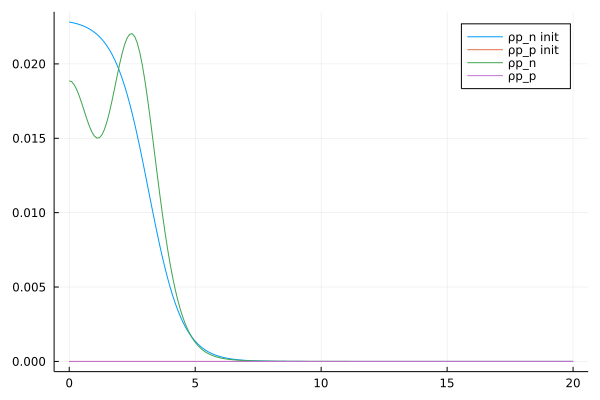

  0.000005 seconds

i = 1: 
spEs[i] = -40.102664153773766
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -35.591920295404115
occ[i] = 0.9981820336589806
Δs[i] = 1.9061683415239785
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -28.03649165849844
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -24.103497003214173
occ[i] = 0.9900469799484397
Δs[i] = 2.188468565189525
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -14.909684269309075
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -13.143444950558907
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 7: 
spEs[i] = -11.659869535510659
occ[i] = 0.19637733947958275
Δs[i] = 2.145660934223696
q

In [32]:
param = My.PhysicalParam(N=10,Z=8, Nr=200)
test_calc_pairing_density!(param; 
    neutron_pairing=true, proton_pairing=false)

In [170]:
function average_density!(dens, dens_new)
    @. begin
        dens.ρ_q = (dens.ρ_q + dens_new.ρ_q)/2
        dens.τ_q = (dens.τ_q + dens_new.τ_q)/2
        dens.ρ_tot = (dens.ρ_tot + dens_new.ρ_tot)/2
        dens.τ_tot = (dens.τ_tot + dens_new.τ_tot)/2
        dens.ρp_q = (dens.ρp_q + dens_new.ρp_q)/2
        dens.ρp_tot = (dens.ρp_tot + dens_new.ρp_tot)/2
    end
end

function HFBCS_calc(param; iter_max=10, κ=[0.3, 0.3], 
        neutron_pairing=false, proton_pairing=false, show_result=false)
    
    @unpack rs, Δr = param
    
    if !neutron_pairing 
        κ[1] = 0.0
    end
    if !proton_pairing
        κ[2] = 0.0
    end
    
    dens = initial_density(param; κ=κ)
    dens_new = initial_density(param; κ=κ)
    states = make_states(param)
    
    Etots  = zeros(Float64, iter_max)
    Etots2 = zeros(Float64, iter_max)
    
    #p1 = plot()
    #p2 = plot()
    
    @time for iter in 1:iter_max
        calc_states!(states, param, dens)
        sort_states!(states)
        
        if neutron_pairing
            calc_pairing_gap!(states, param, dens, 1)
            calc_chemical_potential!(states, param, 1)
            calc_occ_BCS!(states, param, 1)
        else
            calc_occ!(states, param, 1)
        end

        if proton_pairing
            calc_pairing_gap!(states, param, dens, 2)
            calc_chemical_potential!(states, param, 2)
            calc_occ_BCS!(states, param, 2)
        else
            calc_occ!(states, param, 2)
        end
        
        #calc_density!(dens, param, states)
        #calc_pairing_density!(dens, param, states)
        
        if iter ≥ 2
            calc_density!(dens_new, param, states)
            calc_pairing_density!(dens_new, param, states)
            average_density!(dens, dens_new)
        else
            calc_density!(dens, param, states)
            calc_pairing_density!(dens, param, states)
        end
         
        #=
        plot!(p1, rs, dens.ρ_q[:,1]; label="ρ_n")
        plot!(p1, rs, dens.ρ_q[:,2]; label="ρ_p")
        
        plot!(p2, rs, dens.ρp_q[:,1]; label="ρp_n")
        plot!(p2, rs, dens.ρp_q[:,2]; label="ρp_p")
        =#
        
        Etots[iter] = calc_total_energy(param, dens)
        Etots2[iter] = calc_total_energy2(param, dens, states)
    end
    #display(p1)
    #display(p2)
    
    E = calc_total_energy(param, dens)
    E₂ = calc_total_energy2(param, dens, states)
    
    if show_result
        @show E E₂

        p = plot()
        plot!(Etots; label="Etots", marker=:dot)
        plot!(Etots2; label="Etots2", marker=:dot)
        display(p)

        p = plot()
        plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
        plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
        display(p)
        
        p = plot()
        plot!(rs, dens.ρp_q[:,1]; label="ρp_n")
        plot!(rs, dens.ρp_q[:,2]; label="ρp_p")
        display(p)
        
        show_states(states)
    end
    
    return states, dens
end

HFBCS_calc (generic function with 1 method)

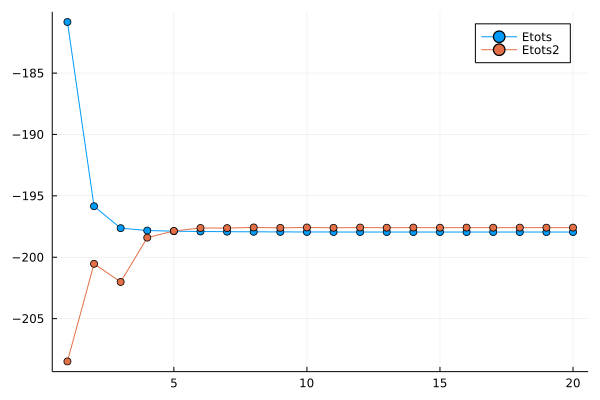

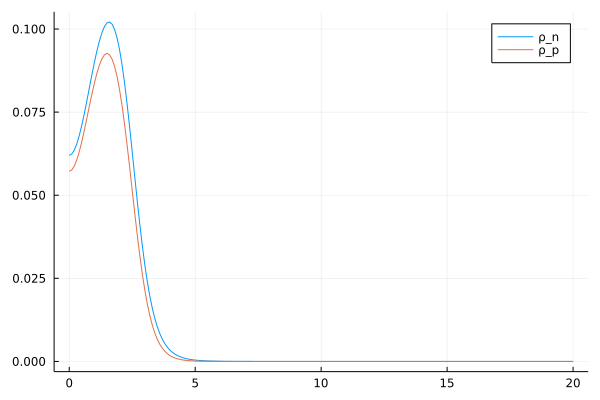

  0.172035 seconds (44.39 k allocations: 104.589 MiB, 4.92% gc time)
E = -197.9510752474062
E₂ = -197.589238704655

i = 1: 
spEs[i] = -38.66113010065753
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -35.57960467318334
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -24.434419569274173
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -21.018164744339746
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -8.025454465118566
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -4.79682766118296
occ[i] = 0.2
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1


i = 7: 
spEs[i] = -4.326835149655633
occ[i] = 0.0
Δs[i] = 0.0

In [171]:
param = My.PhysicalParam(N=10,Z=8, Nr=200)
HF_calc(param; iter_max=20, show_result=true)
;

In [167]:
@show -197.9510752474062 - (-202.359632805465)

-197.9510752474062 - -202.359632805465 = 4.408557558058789


4.408557558058789

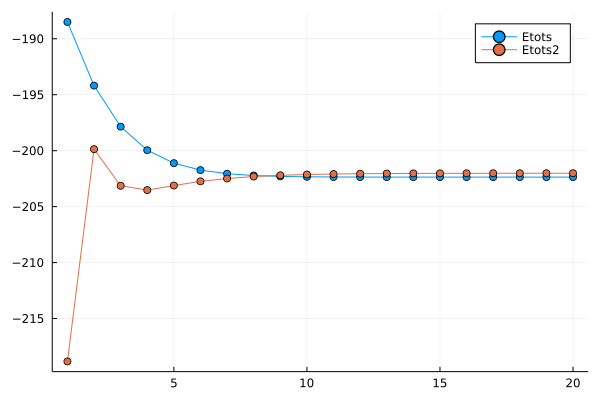

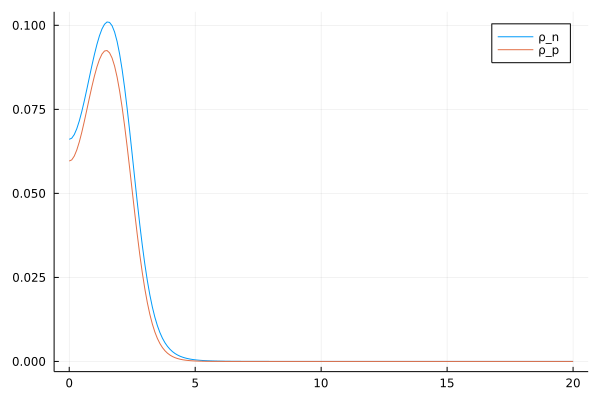

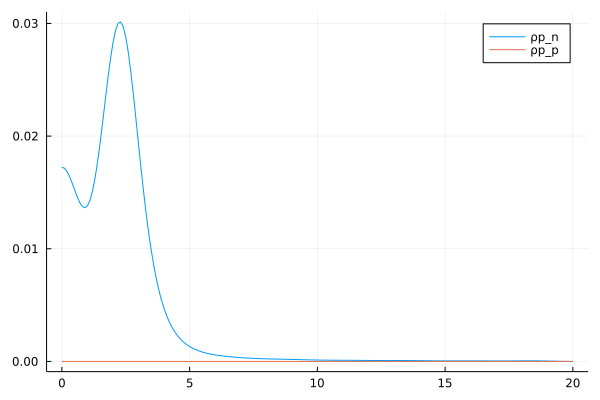

  0.442807 seconds (175.81 k allocations: 297.774 MiB, 4.04% gc time)
E = -202.359632805465
E₂ = -202.01563985065593

i = 1: 
spEs[i] = -37.72397000852819
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -34.76160625718019
occ[i] = 0.999947176976105
Δs[i] = -0.41877662096067153
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -23.413743711823496
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -20.187850600262436
occ[i] = 0.998703823552314
Δs[i] = 1.0269009141778191
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -7.203864683864582
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -4.177601196362507
occ[i] = 0.18978496438957765
Δs[i] = 2.2455429700177123
qnums[i] = Main.My.QuantumNumbers
  l: Int

occ[i] = 0.0
Δs[i] = 0.16813621104109694
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 66: 
spEs[i] = 22.51842759747365
occ[i] = 0.0
Δs[i] = 0.4110313906994034
qnums[i] = Main.My.QuantumNumbers
  l: Int64 4
  j: Int64 1
  q: Int64 2


i = 67: 
spEs[i] = 22.64122704876707
occ[i] = 2.1932303045646417e-5
Δs[i] = 0.2678432711199645
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 68: 
spEs[i] = 22.782103990429338
occ[i] = 0.0
Δs[i] = 0.7900447849135137
qnums[i] = Main.My.QuantumNumbers
  l: Int64 3
  j: Int64 1
  q: Int64 2


i = 69: 
spEs[i] = 22.964769613926578
occ[i] = 0.0001021524628292414
Δs[i] = 0.5846575492549401
qnums[i] = Main.My.QuantumNumbers
  l: Int64 4
  j: Int64 1
  q: Int64 1


i = 70: 
spEs[i] = 23.189730779691615
occ[i] = 5.351104647005611e-5
Δs[i] = 0.42641502527586533
qnums[i] = Main.My.QuantumNumbers
  l: Int64 3
  j: Int64 1
  q: Int64 1


i = 71: 
spEs[i] = 25.74173226836255
occ[i] = 0.0
Δs[i] = 0.0
qnums

In [172]:
param = My.PhysicalParam(N=10,Z=8, Nr=200, Emax=40.0)
HFBCS_calc(param; iter_max=20, show_result=true, 
    neutron_pairing=true, proton_pairing=false)
;

# Three Body Calc.

In [195]:
function make_2body_Hamiltonian(param, states, dens, q)
    @assert q == 1 || q == 2
    
    @unpack Nr, rs, Δr, Vs_eff, tp₀, tp₃, αp, Emax = param
    @unpack nstates_max, qnums, spEs, wfs, occ = states
    @unpack ρ_tot = dens
    
    nstates = length(spEs[spEs .≠ 1e10])
    #@show nstates nstates_max
    
    Hmat = zeros(Float64, nstates*nstates, nstates*nstates)
    
    @. Vs_eff = tp₀ + (1/6)*tp₃*(ρ_tot^αp)
    
    #=
    p = plot(rs, Vs_eff)
    display(p)
    =#
    
    n₂ = 0
    for i₂ in 1:nstates, k₂ in 1:nstates
        if occ[i₂] == 1.0 || occ[k₂] == 1.0
            continue
        end
        if qnums[i₂].l ≠ qnums[k₂].l
            continue
        end
        if qnums[i₂].q ≠ q || qnums[k₂].q ≠ q
            continue
        end
        if spEs[i₂] + spEs[k₂] > Emax
            continue
        end
        #=
        if i₂ > k₂ 
            continue
        end
        =#
        
        n₂ += 1
        l₂ = qnums[i₂].l
        
        Hmat[n₂, n₂] += spEs[i₂] + spEs[k₂]
        
        n₁ = 0
        for i₁ in 1:nstates, k₁ in 1:nstates
            if occ[i₁] == 1.0 || occ[k₁] == 1.0
                continue
            end
            if qnums[i₁].l ≠ qnums[k₁].l
                continue
            end
            if qnums[i₁].q ≠ q || qnums[k₁].q ≠ q
                continue
            end
            if spEs[i₁] + spEs[k₁] > Emax
                continue
            end
            #=
            if i₁ > k₁ 
                continue
            end
            =#
            
            n₁ += 1
            l₁ = qnums[i₁].l
            
            if n₁ > n₂
                break
            end
            
            # radial integral
            I = 0.0
            for ir in 2:Nr+1
                r = rs[ir]
                I += wfs[ir,i₁]*wfs[ir,k₁]*Vs_eff[ir]*wfs[ir,i₂]*wfs[ir,k₂]/(r*r)
            end
            I *= Δr
            
            Hmat[n₁, n₂] += (-1)^(l₁+l₂)*sqrt((2l₁+1)*(2l₂+1))/4π*I
                #sqrt((2-(i₁==k₁))*(2-(i₂==k₂)))
        end
    end
    
    return Symmetric(Hmat[1:n₂, 1:n₂])
end

make_2body_Hamiltonian (generic function with 1 method)

In [183]:
function test_make_2body_Hamiltonian(; N=8, Z=8, lmax=10, Emax=40, v_ρ=930)
    param = My.PhysicalParam(N=8, Z=8, Emax=Emax, lmax=lmax, v_ρ=v_ρ)
    
    states, dens = HF_calc(param)
    @unpack nstates_max, spEs, qnums, occ = states
    
    #show_states(states)
    
    @time Hmat = make_2body_Hamiltonian(param, states, dens, 1)
    
    
    @time ε_2n = eigmin(Hmat) 
    @time vals, vecs, info = eigsolve(Hmat, 1, :SR, eltype(Hmat))
    ε₀ = 0.0
    for i in 1:nstates_max
        if qnums[i].q == 1 && occ[i] ≠ 1.0
            ε₀ = spEs[i]
            break
        end
    end
    Δ = 2ε₀-ε_2n
    @show ε₀ 2ε₀ ε_2n vals[1] Δ
    
    Hmat
end

test_make_2body_Hamiltonian (generic function with 1 method)

In [196]:
test_make_2body_Hamiltonian(;N=8, Z=8, lmax=10, Emax=40.0)

  0.361260 seconds (140.77 k allocations: 230.848 MiB, 4.22% gc time)
  0.338326 seconds (8 allocations: 3.030 GiB, 0.87% gc time)
  0.002905 seconds (11 allocations: 713.859 KiB)
  0.005433 seconds (166 allocations: 191.516 KiB)
ε₀ = -3.8463842817896174
2ε₀ = -7.692768563579235
ε_2n = -14.72089703387223
vals[1] = -14.720897033872198
Δ = 7.028128470292995


280×280 Symmetric{Float64, Matrix{Float64}}:
 -12.5945      -0.220337    -0.403653     …   0.0537377     0.092614
  -0.220337    -2.12071     -0.0274857        0.00184796    0.00293458
  -0.403653    -0.0274857    0.527569         0.00293458    0.00501898
  -0.406306    -0.0334738   -0.0772511        0.00275295    0.00747808
  -0.210191    -0.0282107   -0.0728605        0.00365742    0.0176506
   0.166507    -0.0110262   -0.0423212    …   0.00968744    0.0420064
   0.689931     0.0172716    0.0145465        0.0210744     0.0722371
   1.29856      0.0537377    0.092614         0.0274594     0.0863088
  -1.20235     -0.0301311   -0.0266689        0.0260656     0.042939
  -0.344829    -0.0141232   -0.021492         0.00576828    0.00731988
  -0.417383    -0.0218767   -0.0397376    …   0.00447278    0.00186693
  -0.393348    -0.0257815   -0.0537078       -0.000187555  -0.00919257
  -0.319256    -0.0257691   -0.0596178       -0.00576004   -0.0148539
   ⋮                                     

In [220]:
function calc_potential_3body!(param, states, dens, vec)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, Emax,
        Nr, rs, Vs_central, dψ = param 
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρ_q, ρ_tot = dens
    
    nstates = length(spEs[spEs .≠ 1e10])
    
    temp1 = similar(rs)
    temp2 = similar(rs)
    
    p = plot()

    
    #calc_potential!(param, dens)
    
    @views for q in 1:2
        fill!(temp1, 0)
        fill!(temp2, 0)
        
        @. temp1 += t₀*((1+0.5x₀) - (x₀+0.5)*(q==1))
        
        @. temp1 +=  1/12*t₃*ρ_tot^α*(1+0.5x₃)*(α+2)*(α+1)
        @. temp1 += -1/12*t₃*ρ_tot^α*(x₃+0.5)*(
            α*(α-1)*((ρ_q[:,1]/ρ_tot)^2 + (ρ_q[:,2]/ρ_tot)^2) + 
            4α*(ρ_q[:,q]/ρ_tot) + 2(q==1))
        
        @. temp2 += 1/6*tp₃*αp*ρ_tot^(αp-1)
        
        #=
        p = plot(rs, temp1)
        plot!(p, rs, temp2)
        display(p)
        =#
        
        n₂ = 0
        for i₂ in 1:nstates, k₂ in 1:nstates
            if occ[i₂] == 1.0 || occ[k₂] == 1.0
                continue
            end
            if qnums[i₂].l ≠ qnums[k₂].l
                continue
            end
            if qnums[i₂].q ≠ 1 || qnums[k₂].q ≠ 1
                continue
            end
            if spEs[i₂] + spEs[k₂] > Emax
                continue
            end

            n₂ += 1
            l₂ = qnums[i₂].l

            n₁ = 0
            for i₁ in 1:nstates, k₁ in 1:nstates
                if occ[i₁] == 1.0 || occ[k₁] == 1.0
                    continue
                end
                if qnums[i₁].l ≠ qnums[k₁].l
                    continue
                end
                if qnums[i₁].q ≠ 1 || qnums[k₁].q ≠ 1
                    continue
                end
                if spEs[i₁] + spEs[k₁] > Emax
                    continue
                end

                n₁ += 1
                l₁ = qnums[i₁].l
                
                if k₁ == k₂ 
                    @. Vs_central[:,q] += 2*vec[n₁]*vec[n₂]*
                        wfs[:,i₁]*temp1*wfs[:,i₂]
                    
                    plot!(p, rs, (@. 2*vec[n₁]*vec[n₂]*wfs[:,i₁]*wfs[:,i₂]))
                end
                
                
                #=
                @. Vs_central[:,q] += vec[n₁]*vec[n₂]*
                    (-1)^(l₁+l₂)*sqrt((2l₁+1)*(2l₂+1))/4π*
                    wfs[:,i₁]*wfs[:,k₁]*temp2*
                    wfs[:,i₂]*wfs[:,k₂]/(rs*rs)
                =#
            end
        end
    end
    
    display(p)
end


function test_calc_potential_3body!(param)
    @unpack rs, Vs_central = param
    
    p = plot()
    
    states, dens = HF_calc(param)
    
    Hmat = make_2body_Hamiltonian(param, states, dens, 1)
    vals, vecs, info = eigsolve(Hmat, 1, :SR, eltype(Hmat))
    
    @time calc_potential!(param, dens)
    plot!(p, rs, Vs_central[:,1]; label="V_n")
    plot!(p, rs, Vs_central[:,2]; label="V_p")
    
    dens = initial_density(param)
    
    @time calc_potential_3body!(param, states, dens, vecs[1])
    plot!(p, rs, Vs_central[:,1]; label="V_n 3body")
    plot!(p, rs, Vs_central[:,2]; label="V_p 3body")
end

test_calc_potential_3body! (generic function with 1 method)

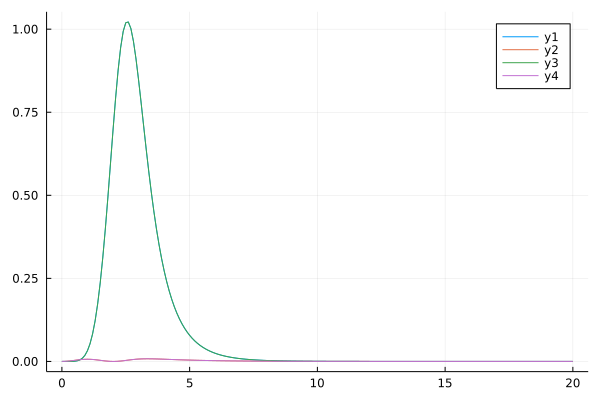

  0.106339 seconds (36.28 k allocations: 76.567 MiB, 7.86% gc time)
  0.000017 seconds
  0.010955 seconds (227.12 k allocations: 4.636 MiB)


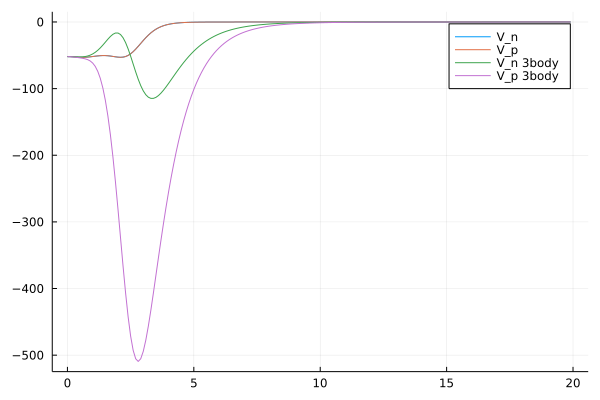

In [221]:
param = My.PhysicalParam(N=8, Z=8, Emax=0.0, lmax=10)
test_calc_potential_3body!(param)